check this doc for detail:
https://librosa.github.io/librosa_gallery/auto_examples/plot_vocal_separation.html#sphx-glr-auto-examples-plot-vocal-separation-py


In [91]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display
%matplotlib inline

In [92]:
train_audio_path = '/home/maikfangogoair/tmp/label_data/'
test_audio_path = '/home/maikfangogoair/test/audio/'

In [130]:
def get_spect(path, window_size=.02, window_stride=.01, window='hamming', normalize = True, max_len=101):
    y, sr = librosa.load(path, sr=None)
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, _ = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)

    # make all spects with the same dims
    # TODO: change that in the future
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:max_len, ]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
#     if normalize:
#         mean = spect.mean()
#         std = spect.std()
#         if std != 0:
#             spect = (spect - mean) /std

    return spect

S_full  = get_spect(train_audio_path + "four/ffb86d3c_nohash_1.wav")


In [143]:
S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(1, sr=16000)))


S_filter = np.minimum(S_full, S_filter)

margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

S_foreground = mask_v * S_full
S_background = mask_i * S_full

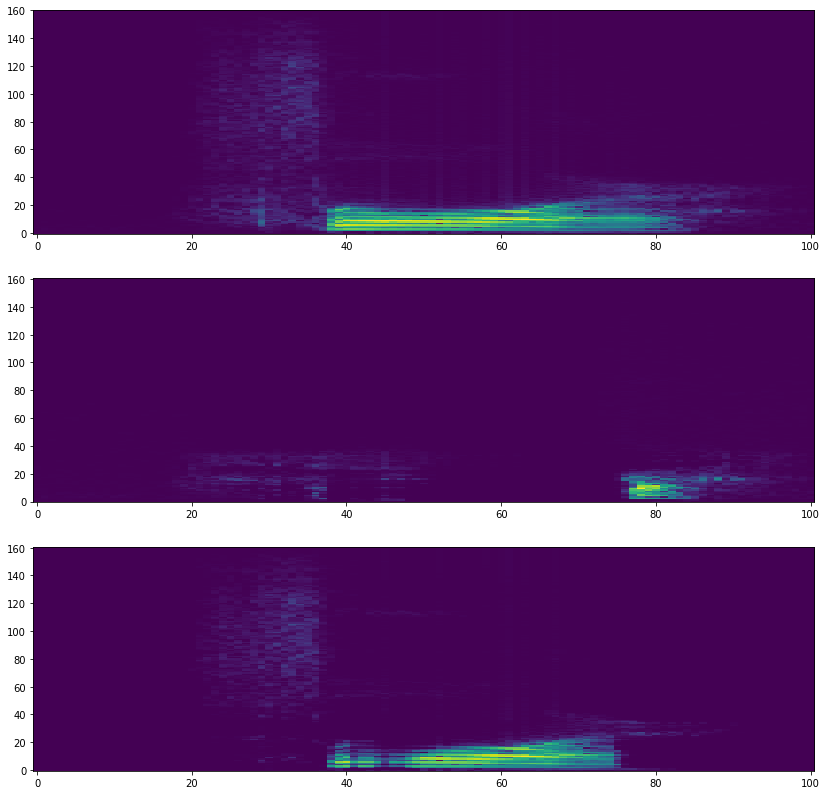

In [144]:
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(311)
ax1.imshow(np.squeeze(S_full, axis=0) , aspect='auto', origin='lower')
ax2 = fig.add_subplot(312)
ax2.imshow(np.squeeze(S_background, axis=0) , aspect='auto', origin='lower')
ax3 = fig.add_subplot(313)
ax3.imshow(np.squeeze(S_foreground, axis=0) , aspect='auto', origin='lower')